### 21년도에 진행했던 퇴근 후 dacon 24등/740
* 처음 만들어본 torch 모형
* 1주일정도 다양한 실험해본 기억

In [1]:
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import auto_encoder
import auto_encoder_functions

In [2]:
train_data = pd.read_csv('../credit_card_fds_dacon/train.csv', index_col = 'ID')
valid_data = pd.read_csv('../credit_card_fds_dacon/val.csv', index_col = 'ID')
test_data = pd.read_csv('../credit_card_fds_dacon/test.csv', index_col = 'ID')

### 1. clustering 기반 이상치 탐지
* 이상치가 적은 cluster만 auto-encoder로 학습하자

In [3]:
### 표준화
scaler = StandardScaler()
scaler.fit(train_data)

train_s = pd.DataFrame(scaler.transform(train_data))
train_s.index = train_data.index
valid_s = pd.DataFrame(scaler.transform(valid_data.drop('Class',axis=1)))
valid_s.index = valid_data.index
test_s = pd.DataFrame(scaler.transform(test_data))
test_s.index = test_data.index

In [4]:
ml_clust = KMeans(n_clusters = 1000, random_state = 10)
ml_clust.fit(normalize(train_data))

train_clust = pd.Series(ml_clust.predict(normalize(train_data)))
valid_clust = pd.Series(ml_clust.predict(normalize(valid_data.drop('Class',axis=1))))
test_clust = pd.Series(ml_clust.predict(normalize(test_data)))

train_clust.index = train_data.index
valid_clust.index = valid_data.index
test_clust.index = test_data.index

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
valid_clust.loc[valid_data['Class']==1].value_counts() # 부정 거래로 탐지된 데이터가 존재하는 clust들

382    11
86      9
628     5
333     1
884     1
958     1
78      1
28      1
Name: count, dtype: int64

In [6]:
preds = pd.DataFrame(test_clust.apply(lambda x : x in [382, 86, 628]).astype(int))
preds.columns = ['Class']
# preds.to_csv('../credit_card_fds_dacon/submissions/modeling_v4.csv') # clustering만 하여 제출해보기

### 2. Auto-Encoder

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 150
learning_rate = 1e-3
batch_size = 2**11
SEED = 10

In [8]:
train_loader = TensorDataset(tensor(train_data.loc[train_clust.apply(lambda x : x not in [431, 235, 233, 93, 409, 43, 11, 18])].values)) # 이상치 존재 데이터 제거
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)

valid_loader = TensorDataset(tensor(valid_data.drop('Class', axis=1).values), tensor(valid_data['Class'].values))
valid_loader = DataLoader(valid_loader, batch_size=batch_size, shuffle=False)

test_loader = TensorDataset(tensor(test_data.values))
test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)

In [9]:
seed = 1004
torch.manual_seed(seed) # Seed 고정

model = auto_encoder.AutoEncoder()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

auto_encoder_functions.train(model, optimizer, train_loader, valid_loader, scheduler, device, epochs)

C:\Users\PC\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train loss :  0.27659174568419137  & valid f1-score :  0.5378234758406146  & epoch :  1  & time 1.618363857269287
best model save at encoder_model.pt
train loss :  0.1578877865834954  & valid f1-score :  0.6262641779317848  & epoch :  2  & time 3.245729684829712
best model save at encoder_model.pt
train loss :  0.131425210013843  & valid f1-score :  0.7755189825957229  & epoch :  3  & time 4.8861000537872314
best model save at encoder_model.pt
train loss :  0.1158005979047095  & valid f1-score :  0.8483089717392718  & epoch :  4  & time 6.392439126968384
best model save at encoder_model.pt
train loss :  0.1074417503025653  & valid f1-score :  0.8649298777330293  & epoch :  5  & time 8.005802631378174
best model save at encoder_model.pt
train loss :  0.09915590680259209  & valid f1-score :  0.8507277214084326  & epoch :  6  & time 9.61516523361206
train loss :  0.09496861624553306  & valid f1-score :  0.8391274530491665  & epoch :  7  & time 11.220526933670044
train loss :  0.0894281539

### 탐색
* cosin 유사도, euclidean 유사도에 따른 부정거래 점 찍어보자

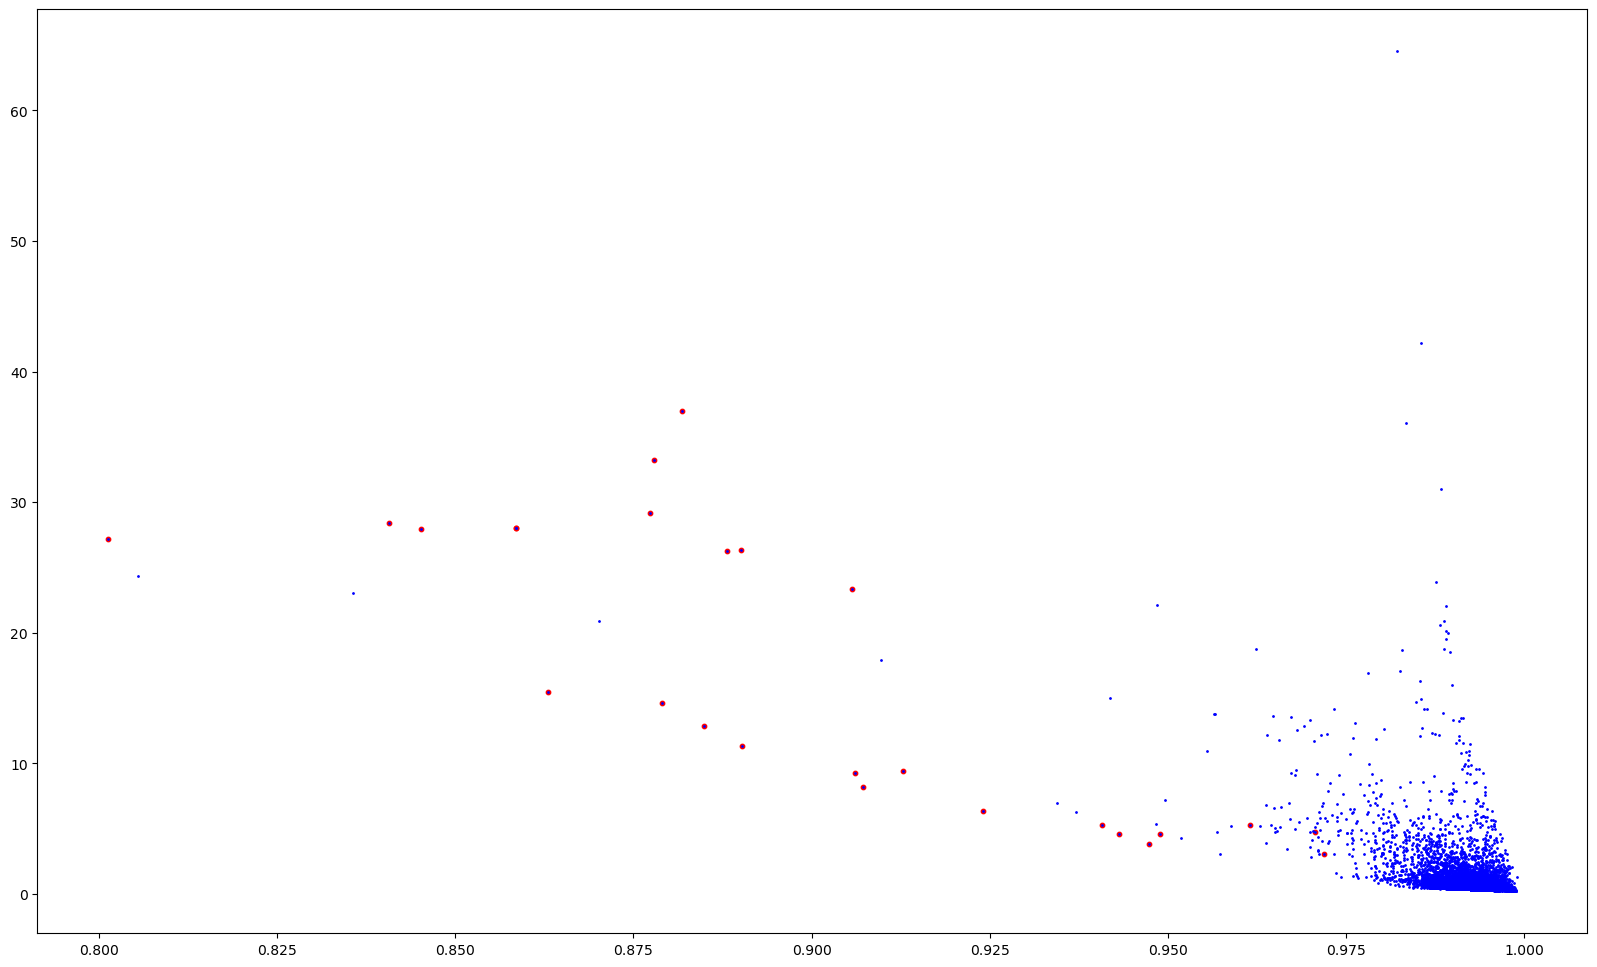

In [10]:
model = torch.load('../credit_card_fds_dacon/encoder_model.pt')
preds = pd.DataFrame(auto_encoder_functions.prediction(model, valid_loader, device))
preds.index = valid_data.index
preds.columns = ['Cos']

preds['Eucl'] = auto_encoder_functions.prediction2(model, valid_loader, device)

fig, ax = plt.subplots(1,1,figsize=(20,12))
ax.scatter(preds.loc[valid_data['Class'] == 1]['Cos'], preds.loc[valid_data['Class'] == 1]['Eucl'], color = 'red', label = '1', s=10)
ax.scatter(preds['Cos'], preds['Eucl'], s = 1, label = '0', color = 'blue')

In [11]:
preds = pd.DataFrame(auto_encoder_functions.prediction(model, test_loader, device))
preds.index = test_data.index
preds['Class'] = preds[0] < 0.95
preds.head()

,0,Class
ID,,
AAAA0x1,0.995749,False
AAAA0x2,0.989064,False
AAAA0x5,0.994042,False
AAAA0x7,0.991972,False
AAAA0xc,0.997698,False


In [13]:
preds['Class'].astype(int).to_csv('../credit_card_fds_dacon/submissions/clust_auto_refer.csv')